In [42]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import os

In [97]:
IMAGE_SIZE=256
BATCH_SIZE=32
EPOCHS = 50
CHANNELS=3

Load the DataSet

In [98]:
dataset = tf.keras.utils.image_dataset_from_directory(
    "/Users/hp/Desktop/Plant disease detection/PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),  # Added a comma here
    batch_size=BATCH_SIZE
)


Found 2152 files belonging to 3 classes.


In [99]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [100]:
len(dataset)

68

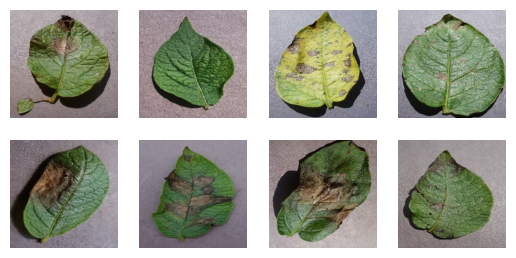

In [101]:
for image_batch, label_batch in dataset.take(1):
    for i in range (8):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        # plt.title(class_name[label_batch[i]])
        plt.axis("off")

In [102]:
# 80%==>train
# 10%==>validation
# 10%==>test


In [103]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [104]:
train_ds = dataset.take(54)
len(train_ds)

54

In [105]:
test_ds=dataset.skip(54)
len(test_ds)

14

In [106]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [107]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [108]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [109]:
def get_dataset_partitons_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=12)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)

    train_ds=ds.take(train_size)

    val_ds=ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds

In [110]:
train_ds,val_ds,test_ds=get_dataset_partitons_tf(dataset)

In [111]:
len(train_ds)

54

In [112]:
len(val_ds)

6

In [113]:
len(test_ds)

8

In [114]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [115]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE , IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

Data Augmentation


In [116]:
data_aumentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

Model Building

In [118]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE,CHANNELS)
n_classes = 3
model = models.Sequential([
    resize_and_rescale,
    data_aumentation,
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])
model.build(input_shape=input_shape)


In [119]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_9 (Sequential)   (256, 256, 256)           0         
                                                                 
 sequential_10 (Sequential)  (256, 256, 256)           0         
                                                                 
 conv2d_31 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                

In [120]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [121]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data=val_ds
)

Epoch 1/50
54/54 [==============================] - 97s 2s/step - loss: 0.9342 - accuracy: 0.4554 - val_loss: 0.8252 - val_accuracy: 0.4844
Epoch 2/50
54/54 [==============================] - 80s 1s/step - loss: 0.8567 - accuracy: 0.5775 - val_loss: 0.8553 - val_accuracy: 0.5625
Epoch 3/50
54/54 [==============================] - 78s 1s/step - loss: 0.6331 - accuracy: 0.7465 - val_loss: 0.5529 - val_accuracy: 0.7865
Epoch 4/50
54/54 [==============================] - 85s 2s/step - loss: 0.5008 - accuracy: 0.7986 - val_loss: 0.3828 - val_accuracy: 0.8438
Epoch 5/50
54/54 [==============================] - 84s 2s/step - loss: 0.4042 - accuracy: 0.8432 - val_loss: 0.4852 - val_accuracy: 0.7865
Epoch 6/50
54/54 [==============================] - 82s 2s/step - loss: 0.3136 - accuracy: 0.8721 - val_loss: 0.5373 - val_accuracy: 0.7656
Epoch 7/50
54/54 [==============================] - 81s 1s/step - loss: 0.2559 - accuracy: 0.9010 - val_loss: 0.3735 - val_accuracy: 0.8438
Epoch 8/50
54/54 [==

Testing The Model

In [122]:
scores=model.evaluate(test_ds)

8/8 [==============================] - 5s 413ms/step - loss: 0.0777 - accuracy: 0.9688


In [123]:
scores

[0.07773623615503311, 0.96875]

In [125]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [126]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [127]:
history.history['accuracy']

[0.45543980598449707,
 0.5775462985038757,
 0.7465277910232544,
 0.7986111044883728,
 0.8431712985038757,
 0.8721064925193787,
 0.9010416865348816,
 0.9293981194496155,
 0.9403935074806213,
 0.9346064925193787,
 0.9230324029922485,
 0.9432870149612427,
 0.9548611044883728,
 0.9670138955116272,
 0.9461805820465088,
 0.9560185074806213,
 0.9768518805503845,
 0.9664351940155029,
 0.9733796119689941,
 0.9693287014961243,
 0.9461805820465088,
 0.9780092835426331,
 0.9675925970077515,
 0.9849537014961243,
 0.9791666865348816,
 0.9890046119689941,
 0.9872685074806213,
 0.9832175970077515,
 0.9785879850387573,
 0.9890046119689941,
 0.9890046119689941,
 0.9728009104728699,
 0.9814814925193787,
 0.9814814925193787,
 0.9942129850387573,
 0.9895833134651184,
 0.9913194179534912,
 0.9756944179534912,
 0.9936342835426331,
 0.9947916865348816,
 0.9861111044883728,
 0.9942129850387573,
 0.9936342835426331,
 0.9907407164573669,
 0.9976851940155029,
 0.9971064925193787,
 0.9942129850387573,
 0.991319417

In [128]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

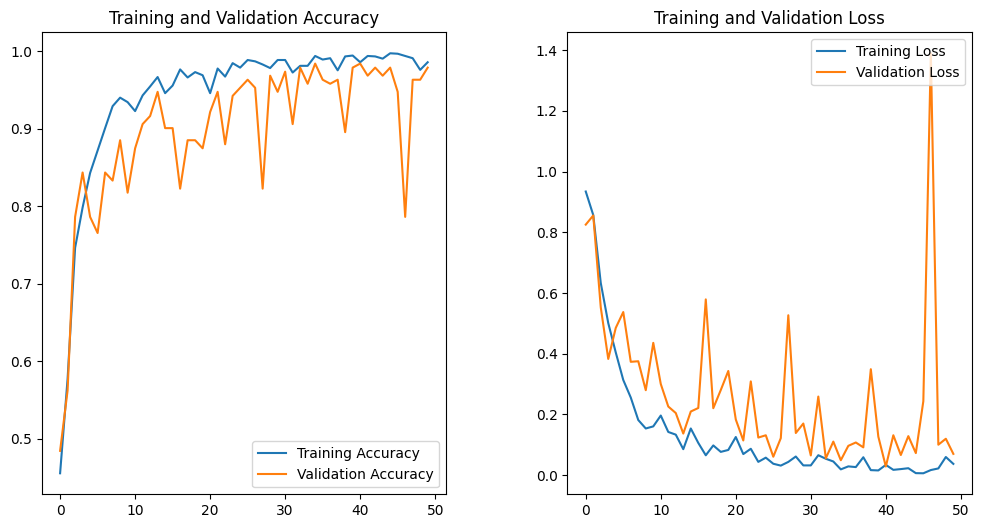

In [132]:
plt.figure(figsize=(12, 6))
plt.subplots_adjust(wspace=0.3)  # Adjust the horizontal spacing between subplots

# First subplot for accuracy
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label="Training Accuracy")
plt.plot(range(EPOCHS), val_acc, label="Validation Accuracy")
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Second subplot for loss
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label="Training Loss")
plt.plot(range(EPOCHS), val_loss, label="Validation Loss")
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()


Making Prediction

In [139]:
import numpy as np

First Image to Predict
actual label :  Potato___Late_blight
1/1 [==============================] - 0s 361ms/step
Predicted Label:  Potato___Late_blight


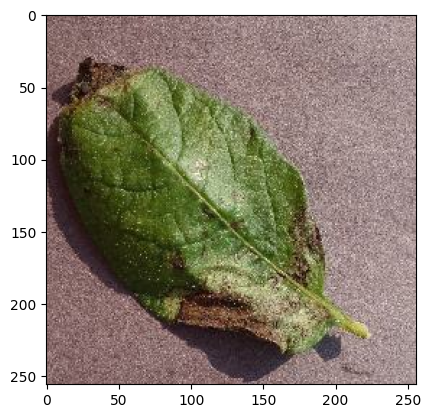

In [144]:
for images_batch, labeld_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = label_batch[0].numpy()

    print("First Image to Predict")
    plt.imshow(first_image)
    print("actual label : ",class_names[first_label])

    batch_prediction = model.predict(image_batch)
    print("Predicted Label: ",class_names[np.argmax(batch_prediction[0])])

In [146]:
def predict(model,img):
    img_array = tf.keras.preprocessing.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 [==============================] - 0s 56ms/step


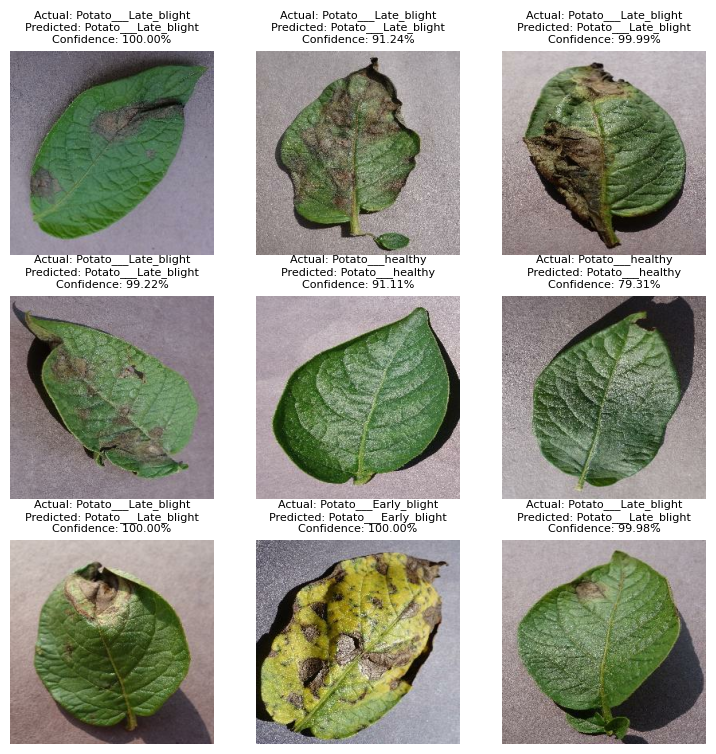

In [158]:
import tensorflow as tf
import matplotlib.pyplot as plt

plt.figure(figsize=(9,9))
for images, labels in test_ds.take(1):
    for i in range(1, 10):  # Changed the range to start from 1
        ax = plt.subplot(3, 3, i)
        plt.imshow(images[i-1].numpy().astype("uint8"))  # Adjusted the index
        image = images[i-1].numpy()  # Adjusted the index
        img_array = tf.image.convert_image_dtype(image, tf.float32)
        img_array = tf.expand_dims(img_array, 0)
        predictions = model.predict(img_array)

        predicted_class = class_names[tf.argmax(predictions[0])]
        confidence = tf.reduce_max(predictions[0]).numpy() * 100
        actual_class = class_names[labels[i-1]]

        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence:.2f}%", fontsize=8)
        plt.axis("off")

plt.show()
